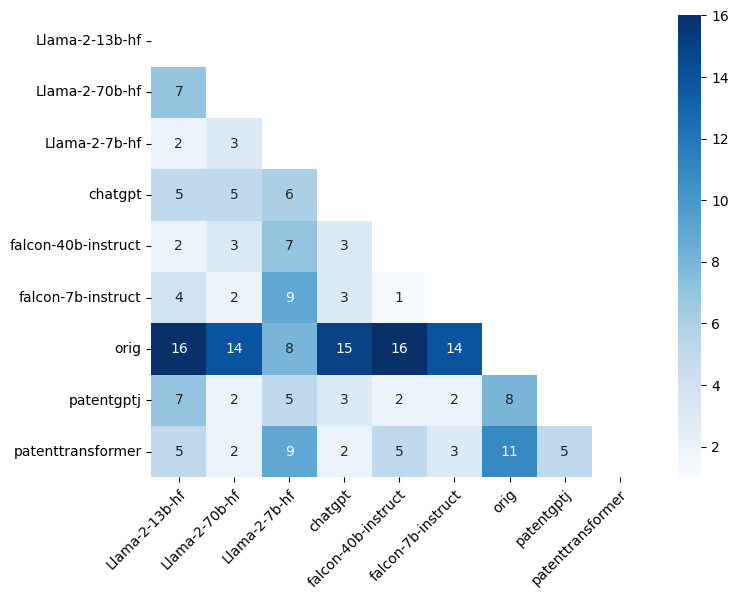

In [1]:
import json
import numpy as np
from collections import defaultdict


with open('./human_eval_c2c.json') as f:  annotations = json.load(f)
with open('./selected_pairs_c2c.jsonl') as f:  meta = [json.loads(line) for line in f]
meta_pairs = []
for meta_selection in meta:
    selections = list(meta_selection.values())[0]
    for pair in selections:
        meta_pairs.append(pair)
meta_pairs_annotated = meta_pairs[:len(annotations)]


# model frequency in selected pairs
model_freq = defaultdict(int)
for pair in meta_pairs:
    model1, model2 = pair
    model_freq[model1] += 1
    model_freq[model2] += 1
model_freq = dict(model_freq)


# create matrix of model pairs
model_names = list(model_freq.keys())
model_names = sorted(model_names)
model_pairs = np.zeros((len(model_names), len(model_names)))
for pair in meta_pairs:
    model1, model2 = pair
    model_pairs[model_names.index(model1), model_names.index(model2)] += 1
    model_pairs[model_names.index(model2), model_names.index(model1)] += 1


# plot the heatmap of model pairs, only show upper triangle of the matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(model_pairs, columns=model_names, index=model_names)
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 6))
sns.heatmap(df, mask=mask, annot=True, fmt='.0f', cmap='Blues')
# Adjust x-tick labels
plt.xticks(np.arange(len(model_names))+0.5, model_names, rotation=45, ha="right", rotation_mode='anchor')

plt.savefig('./figures/c2c_model1_model2', dpi=300)

In [4]:
import json

with open('./selected_pairs_c2c.jsonl') as f:  meta = [json.loads(line) for line in f]
meta_pairs = []
for meta_selection in meta:
    selections = list(meta_selection.values())[0]
    for pair in selections:
        meta_pairs.append(pair)
meta_pairs_annotated = meta_pairs[:len(annotations)]

# model frequency in selected pairs
model_freq = defaultdict(int)
for pair in meta_pairs:
    model1, model2 = pair
    model_freq[model1] += 1
    model_freq[model2] += 1
model_freq = dict(model_freq)

with open('./annotations/export_45979_project-45979-at-2023-12-08-10-45-684ab03f.json') as f:  annotations = json.load(f)

new_annotations = []
for annot in annotations:
    selected_annotations = []
    for la in annot["annotations"]:
        if "zuo" in la["completed_by"]["email"].lower():
            selected_annotations.append(la)
    if len(selected_annotations) > 0:
        annot["annotations"] = [d["result"] for d in selected_annotations][0]
        annot["annotations"] = [a for a in annot["annotations"] if a["type"] != "labels"]
        new_annotations.append(annot["annotations"])
    else: # skipped or emply annotations
        annot["annotations"] = []
        new_annotations.append(annot["annotations"])

annotations = new_annotations            
# save annotations with indent=4
with open('./annotations/version3_c2c.txt', 'w') as f:
    for annotation in annotations:
        f.write(json.dumps(annotation))
        f.write('\n')

Error in annotation {'id': 'V6s22yjiVm', 'type': 'textarea', 'value': {'text': ['more than one claim generated']}, 'origin': 'manual', 'to_name': 'answer2', 'from_name': 'comment2'} in pair ('Llama-2-7b-hf', 'orig')
Error in annotation {'id': 'PdupaKO9dF', 'type': 'textarea', 'value': {'text': ['repetition of instruction']}, 'origin': 'manual', 'to_name': 'answer2', 'from_name': 'comment2'} in pair ('Llama-2-7b-hf', 'falcon-40b-instruct')
Error in annotation {'id': 'ZzkqsjdCuW', 'type': 'textarea', 'value': {'text': ['repetition of instruction']}, 'origin': 'manual', 'to_name': 'answer2', 'from_name': 'comment2'} in pair ('orig', 'falcon-40b-instruct')


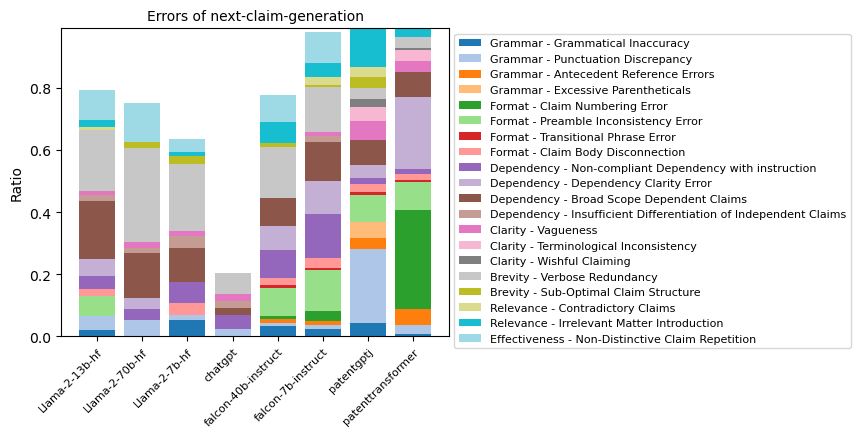

In [5]:
from collections import defaultdict

default_errors = ["Grammar - Grammatical Inaccuracy", 
                  "Grammar - Punctuation Discrepancy", 
                  "Grammar - Antecedent Reference Errors", 
                  "Grammar - Excessive Parentheticals",
                  "Format - Claim Numbering Error",
                  "Format - Preamble Inconsistency Error",
                  "Format - Transitional Phrase Error",
                  "Format - Claim Body Disconnection",
                  "Dependency - Non-compliant Dependency with instruction",
                  "Dependency - Dependency Clarity Error",
                  "Dependency - Broad Scope Dependent Claims",
                  "Dependency - Insufficient Differentiation of Independent Claims",
                  "Clarity - Vagueness",
                  "Clarity - Terminological Inconsistency",
                  "Clarity - Wishful Claiming",
                  "Brevity - Verbose Redundancy",
                  "Brevity - Sub-Optimal Claim Structure",
                  "Relevance - Contradictory Claims",
                  "Relevance - Irrelevant Matter Introduction",
                  "Effectiveness - Non-Distinctive Claim Repetition",
                  "Other",
                  "Correct"
                  ]
default_errors = {error: 0 for error in default_errors}

# calculate the frequency of each error from previous defined errors
errors = defaultdict(lambda: default_errors.copy())

for (model1, model2), annotation in zip(meta_pairs_annotated, annotations):
    model1_correct, model2_correct = True, True

    for annot in annotation:
        if annot["type"] == "pairwise":
            if annot["value"]["selected"] == "left": to_model = model1
            elif annot["value"]["selected"] == "right": to_model = model2
        elif annot["type"] == "choices":
            to_model = annot["to_name"]
            if annot["to_name"] == "answer1":
                to_model = model1
                model1_correct = False
            elif annot["to_name"] == "answer2":
                to_model = model2
                model2_correct = False
            for choice in annot["value"]["choices"]:
                errors[to_model][choice.split("(")[0].strip()] += 1
        elif annot["type"] == "textarea" and annot["value"]["text"][0] == "both bad":
            model1_correct, model2_correct = False, False
        else:
            print("Error in annotation", annot, "in pair", (model1, model2))

    if model1_correct:
        errors[model1]["Correct"] += 1
    if model2_correct:
        errors[model2]["Correct"] += 1


# sort the errors by model name, normalize the frequency of errors by sum of error frequency of each model
errors = sorted(errors.items(), key=lambda x: x[0])
errors = [(model, {error: freq / sum(error_freq.values()) for error, freq in error_freq.items()}) for model, error_freq in errors if model != "orig"]

############################################################################################################
# draw barchart of error ratios
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming 'error_names' contains unique types of errors
error_names = list(default_errors.keys())
error_names.remove('Other')
error_names.remove('Correct')

# Define a manual selection of distinct colors from the Tableau 20 palette
# These colors are picked for their distinctness and visual appeal
tableau20 = [
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
]

# Fix size of the plot
plt.figure(figsize=(5, 4))

model_names, error_freqs = zip(*errors)
error_freqs = [[error_freq.get(error, 0) for error in error_names] for error_freq in error_freqs]
error_freqs = np.array(error_freqs)

bottom = np.zeros(len(model_names))
for i, error_name in enumerate(error_names):
    # Assign colors from the Tableau 20 palette, cycling if necessary
    color = tableau20[i % len(tableau20)]
    plt.bar(model_names, error_freqs[:, i], bottom=bottom, label=error_name, color=color, width=0.8)
    bottom += error_freqs[:, i]


plt.xticks(rotation=45, ha="right", rotation_mode='anchor', fontsize=8)
plt.ylabel("Ratio")
plt.title("Errors of next-claim-generation", fontsize=10)

# Put legend outside of the plot on the upper left
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=8)

# Save the plot
plt.savefig('./figures/c2c_error_ratio', dpi=300)

# Show the plot
plt.show()


Error in annotation {'id': 'V6s22yjiVm', 'type': 'textarea', 'value': {'text': ['more than one claim generated']}, 'origin': 'manual', 'to_name': 'answer2', 'from_name': 'comment2'} in pair ('Llama-2-7b-hf', 'orig')
Error in annotation {'id': 'PdupaKO9dF', 'type': 'textarea', 'value': {'text': ['repetition of instruction']}, 'origin': 'manual', 'to_name': 'answer2', 'from_name': 'comment2'} in pair ('Llama-2-7b-hf', 'falcon-40b-instruct')
Error in annotation {'id': 'ZzkqsjdCuW', 'type': 'textarea', 'value': {'text': ['repetition of instruction']}, 'origin': 'manual', 'to_name': 'answer2', 'from_name': 'comment2'} in pair ('orig', 'falcon-40b-instruct')


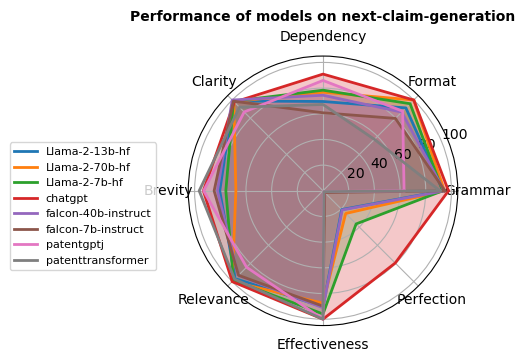

In [6]:
# calculate the number of times each model is selected
choices_with_models = defaultdict(int)
# calculate the number of times each model is compared with the original
freq_with_orig, choices_with_orig = defaultdict(int), defaultdict(int)

default_errors = ["Grammar - Grammatical Inaccuracy", 
                  "Grammar - Punctuation Discrepancy", 
                  "Grammar - Antecedent Reference Errors", 
                  "Grammar - Excessive Parentheticals",
                  "Format - Claim Numbering Error",
                  "Format - Preamble Inconsistency Error",
                  "Format - Transitional Phrase Error",
                  "Format - Claim Body Disconnection",
                  "Dependency - Non-compliant Dependency with instruction",
                  "Dependency - Dependency Clarity Error",
                  "Dependency - Broad Scope Dependent Claims",
                  "Dependency - Insufficient Differentiation of Independent Claims",
                  "Clarity - Vagueness",
                  "Clarity - Terminological Inconsistency",
                  "Clarity - Wishful Claiming",
                  "Brevity - Verbose Redundancy",
                  "Brevity - Sub-Optimal Claim Structure",
                  "Relevance - Contradictory Claims",
                  "Relevance - Irrelevant Matter Introduction",
                  "Effectiveness - Non-Distinctive Claim Repetition",
                  "Other",
                  "Correct"
                  ]
default_errors = {error: 0 for error in default_errors}

# calculate the frequency of each error from previous defined errors
errors = defaultdict(lambda: default_errors.copy())

for (model1, model2), annotation in zip(meta_pairs_annotated, annotations):

    model1_correct, model2_correct = True, True
    has_preference = False

    for annot in annotation:
        if annot["type"] == "pairwise":
            # if orig is in the comparison, add to choices_with_orig
            if "orig" in [model1, model2]:
                if model1 == "orig": 
                    freq_with_orig[model2] += 1
                    if annot["value"]["selected"] == "left": to_model = model1
                    elif annot["value"]["selected"] == "right": to_model = model2
                    choices_with_orig[to_model] += 1
                elif model2 == "orig": 
                    freq_with_orig[model1] += 1
                    if annot["value"]["selected"] == "left": to_model = model1
                    elif annot["value"]["selected"] == "right": to_model = model2
                    choices_with_orig[to_model] += 1
            # if orig is not in the comparison, add to choices
            else:
                if annot["value"]["selected"] == "left": to_model = model1
                elif annot["value"]["selected"] == "right": to_model = model2
                choices_with_models[to_model] += 1
            has_preference = True

        elif annot["type"] == "choices":
            to_model = annot["to_name"]
            if annot["to_name"] == "answer1":
                to_model = model1
                model1_correct = False
            elif annot["to_name"] == "answer2":
                to_model = model2
                model2_correct = False
            for choice in annot["value"]["choices"]:
                errors[to_model][choice.split("(")[0].strip()] += 1
        elif annot["type"] == "textarea" and annot["value"]["text"][0] == "both bad":
            model1_correct, model2_correct = False, False
            has_preference = True
        else:
            print("Error in annotation", annot, "in pair", (model1, model2))

    if model1_correct:
        errors[model1]["Correct"] += 1
    if model2_correct:
        errors[model2]["Correct"] += 1

    if has_preference == False:
        if "orig" in [model1, model2]:
            if model1 == "orig": 
                freq_with_orig[model2] += 1
                choices_with_orig[model2] += 1
            elif model2 == "orig": 
                freq_with_orig[model1] += 1
                choices_with_orig[model1] += 1
        # if orig is not in the comparison, add to choices
        else:
            choices_with_models[model1] += 1
            choices_with_models[model2] += 1
        

# choices is the combination of choices_with_models and choices_with_orig
choices = {model: choices_with_models[model] + choices_with_orig[model] for model in choices_with_models}

# sort the choices by model name, normalize the frequency of choices by model frequency
choices = sorted(choices.items(), key=lambda x: x[0])
choices = [(model, freq / model_freq[model]) for model, freq in choices if model != "orig"]

choices_with_models = sorted(choices_with_models.items(), key=lambda x: x[0])
choices_with_models = [(model, freq / (model_freq[model] - freq_with_orig[model])) for model, freq in choices_with_models if model != "orig"]

choices_with_orig = sorted(choices_with_orig.items(), key=lambda x: x[0])
choices_with_orig = [(model, freq / freq_with_orig[model]) for model, freq in choices_with_orig if model != "orig"]


# error mapping
error_type_mapping = {
    "Grammar - Grammatical Inaccuracy": "Grammar",
    "Grammar - Punctuation Discrepancy": "Grammar",
    "Grammar - Antecedent Reference Errors": "Grammar", 
    "Grammar - Excessive Parentheticals": "Grammar",
    "Format - Claim Numbering Error": "Format",
    "Format - Preamble Inconsistency Error": "Format",
    "Format - Transitional Phrase Error": "Format",
    "Format - Claim Body Disconnection": "Format",
    "Dependency - Non-compliant Dependency with instruction": "Dependency",
    "Dependency - Dependency Clarity Error": "Dependency",
    "Dependency - Broad Scope Dependent Claims": "Dependency",
    "Dependency - Insufficient Differentiation of Independent Claims": "Dependency",
    "Clarity - Vagueness": "Clarity",
    "Clarity - Terminological Inconsistency": "Clarity",
    "Clarity - Wishful Claiming": "Clarity",
    "Brevity - Verbose Redundancy": "Brevity",
    "Brevity - Sub-Optimal Claim Structure": "Brevity",
    "Relevance - Contradictory Claims": "Relevance",
    "Relevance - Irrelevant Matter Introduction": "Relevance",
    "Effectiveness - Non-Distinctive Claim Repetition": "Effectiveness",
    "Correct": "Perfection"
}

# update the errors and frequencies with the error mapping, if multiple errors are mapped to the same type, add the frequencies
errors = sorted(errors.items(), key=lambda x: x[0])

for i, (model, error_freq) in enumerate(errors):
    updated_error_freq = {}
    for error_type, freq in error_freq.items():
        updated_error_type = error_type_mapping.get(error_type, error_type)
        updated_error_freq[updated_error_type] = updated_error_freq.get(updated_error_type, 0) + freq
    errors[i] = (model, updated_error_freq)
    

# sort the errors by model name, normalize the frequency of errors by sum of error frequency of each model
errors = [(model, {error: freq / sum(error_freq.values()) for error, freq in error_freq.items()}) for model, error_freq in errors if model != "orig"]

# Iterate through the errors data and calculate the complement (1 - error rate) for each error type except "Correct"
for i, (model, error_freq) in enumerate(errors):
    for error_type in error_freq:
        if error_type != "Perfection":
            errors[i][1][error_type] = 1 - error_freq[error_type]

############################################################################################################
import matplotlib.pyplot as plt
import numpy as np


# Iterate through the errors data and update error type names
for i, (model, error_freq) in enumerate(errors):
    updated_error_freq = {}
    for error_type, freq in error_freq.items():
        updated_error_type = error_type_mapping.get(error_type, error_type)
        updated_error_freq[updated_error_type] = freq
    errors[i] = (model, updated_error_freq)

# Assuming `choices` and `errors` are provided and have the correct format
# For this example, let's assume default_errors are known and errors is a list of tuples
choices = [(model, round(freq * 100, 2)) for model, freq in choices]
choices_with_models = [(model, round(freq * 100, 2)) for model, freq in choices_with_models]
choices_with_orig = [(model, round(freq * 100, 2)) for model, freq in choices_with_orig]

errors = [(model, {error: round(freq * 100, 2) for error, freq in error_freq.items()}) for model, error_freq in errors]


# Define the error types
error_types = ["Grammar", "Format", "Dependency", "Clarity", "Brevity", "Relevance", "Effectiveness", "Perfection"]

# Calculate the number of variables we're plotting.
num_vars = len(error_types)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is made circular, so we need to "complete the loop" and append the start to the end.
angles += angles[:1]

# Draw one axe per variable and add labels
fig, ax = plt.subplots(figsize=(3.5, 3.5), subplot_kw=dict(polar=True))

# Helper function to draw one model on the chart.
def draw_model(ax, angles, model_name, stats):
    # Plot data and fill with color
    stats += stats[:1]  # Complete the loop
    ax.plot(angles, stats, label=model_name, linewidth=2)
    ax.fill(angles, stats, alpha=0.25)

# Iterate through each model
for model, error_freq in errors:
    stats = [error_freq.get(error, 0) for error in error_types]
    draw_model(ax, angles, model, stats)

# Add attribute labels
ax.set_thetagrids(np.degrees(angles[:-1]), error_types)

# Set the title of the chart
plt.title('Performance of models on next-claim-generation', fontsize=10, y=1.1, fontweight='bold')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(-0.1, 0.7), fontsize=8)

# Show plot
plt.savefig('./figures/c2c_error_polar', dpi=300)

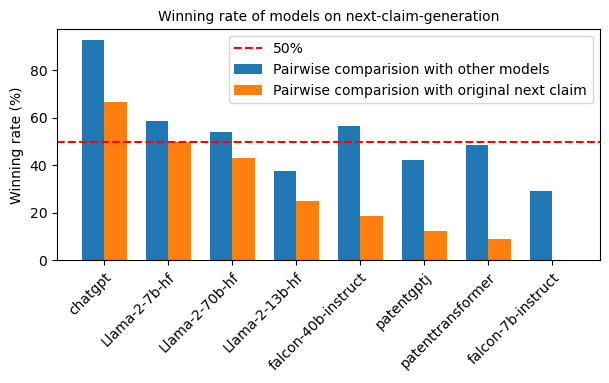

In [7]:
# visualize bar plots of choices_with_models (blue) and choices_with_orig (orange) for each model next to each other
import matplotlib.pyplot as plt
import numpy as np

# Combine the two datasets into a single dataset for sorting
combined_data = sorted(zip(choices_with_models, choices_with_orig), key=lambda x: x[1][1], reverse=True)
choices_with_models_sorted, choices_with_orig_sorted = zip(*combined_data)

# fix size of the plot
plt.figure(figsize=(7, 3))  # Adjust the figure size as needed

model_names, freqs_models = zip(*choices_with_models_sorted)
model_names, freqs_orig = zip(*choices_with_orig_sorted)

width = 0.35  # Width of the bars
bar_positions_models = np.arange(len(model_names))
bar_positions_orig = bar_positions_models + width  # Shift the positions for the second set of bars

plt.bar(bar_positions_models, freqs_models, width=width, label="Pairwise comparision with other models")
plt.bar(bar_positions_orig, freqs_orig, width=width, label="Pairwise comparision with original next claim")

# add red line to 50% for reference
plt.axhline(y=50, color='r', linestyle='--', label="50%")


plt.xticks(bar_positions_models + width / 2, model_names, rotation=45, ha="right", rotation_mode='anchor')
plt.ylabel("Winning rate (%)")
plt.title("Winning rate of models on next-claim-generation", fontsize=10)
plt.legend()

plt.savefig('./figures/c2a_choices_ratio', dpi=300)